# Imports

In [1]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

%matplotlib inline

/Users/JordanVani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Load Data

In [2]:
cam = pd.read_csv("../data/external/cameras.csv")
mn_cam = cam[(cam.boro == "Manhattan") & (cam.people == 1.)].copy()
mn_cam["location"] = mn_cam.zipcode.replace({'10004': 'downtown', '10005': 'downtown', '10006': 'downtown', '10007': 'downtown', '10001': 'midtown', '10002': 'village', '10065': 'uptown', '10165': 'uptown', '10069': 'uptown', '10044': 'uptown', '10275': 'uptown', '10012': 'village', '10013': 'village', '10128': 'uptown', '10028': 'uptown', '10029': 'uptown', '10026': 'uptown', '10027': 'uptown', '10024': 'uptown', '10025': 'uptown', '10022': 'midtown', '10023': 'uptown', '10020': 'midtown', '10021': 'uptown', '10010': 'midtown', '10031': 'uptown', '10003': 'village', '10011': 'village', '10030': 'uptown', '10009': 'village', '10032': 'uptown', '10014': 'village', '10282': 'downtown', '10280': 'downtown', '10281': 'downtown', '10019': 'midtown', '10018': 'midtown', '10039': 'uptown', '10038': 'downtown', '10035': 'uptown', '10034': 'uptown', '10037': 'uptown', '10036': 'midtown', '10017': 'midtown', '10016': 'midtown', '10033': 'uptown', '10111': 'midtown', '00083': 'uptown', '10048': 'downtown'})
mn_cam.head(2)

,cam_id,cctv_id,description,lat,long,people,ribbon,boro,zipcode,location
4,172,11,Baxter St @ Canal Street,40.716623,-73.999186,1,1,Manhattan,10013,village
9,421,438,Broadway @ 51 St,40.761268,-73.983564,1,1,Manhattan,10019,midtown


In [3]:
hdv = pd.read_feather("../data/results/hadive-data.feather").set_index("date")
mn_wd_hdv = hdv[(hdv.cam_id.isin(mn_cam.cam_id.unique())) & (hdv.index.weekday < 5)].copy()
dt_values = [(t[:10], t[11:16]) for t in (mn_wd_hdv.index.round("15Min").values).astype(str)]
mn_wd_hdv["d"] = [x[0] for x in dt_values]
mn_wd_hdv["t"] = [x[1] for x in dt_values]
mn_wd_hdv.head(2)

,cam_id,count,d,t
date,,,,
2017-06-27 20:09:22,368,1,2017-06-27,20:15
2017-06-27 20:09:23,360,1,2017-06-27,20:15


# Analysis

In [4]:
cam_ts = mn_wd_hdv.groupby(["cam_id", "t"]).mean().unstack(level=1)
cam_ts.columns = [pd.to_datetime("9-9-99 " + t) for t in cam_ts.columns.droplevel()]
cam_ts = ((cam_ts.T - cam_ts.T.mean()) / cam_ts.T.std()).T
cam_ts = mn_cam[["cam_id", "location"]].set_index("cam_id").merge(cam_ts, left_index=True, right_index=True)
cam_ts.head(2)

,location,1999-09-09 00:00:00,1999-09-09 00:15:00,1999-09-09 00:30:00,1999-09-09 00:45:00,1999-09-09 01:00:00,1999-09-09 01:15:00,1999-09-09 01:30:00,1999-09-09 01:45:00,1999-09-09 02:00:00,...,1999-09-09 21:30:00,1999-09-09 21:45:00,1999-09-09 22:00:00,1999-09-09 22:15:00,1999-09-09 22:30:00,1999-09-09 22:45:00,1999-09-09 23:00:00,1999-09-09 23:15:00,1999-09-09 23:30:00,1999-09-09 23:45:00
cam_id,,,,,,,,,,,,,,,,,,,,,
172,village,-0.919192,-1.062203,-1.073249,-1.101855,-1.176836,-1.214704,-1.208705,-1.202753,-1.178606,...,-0.492206,-0.607640,-0.612585,-0.617711,-0.704241,-0.720724,-0.741379,-0.783647,-0.862345,-0.918431
421,midtown,-1.002025,-1.044281,-1.156339,-1.206727,-1.195791,-1.134802,-1.206475,-1.220986,-1.205142,...,-0.345711,0.039873,-0.546930,-0.648501,-0.698085,-0.313473,-0.653949,-0.905453,-0.837453,-0.931698


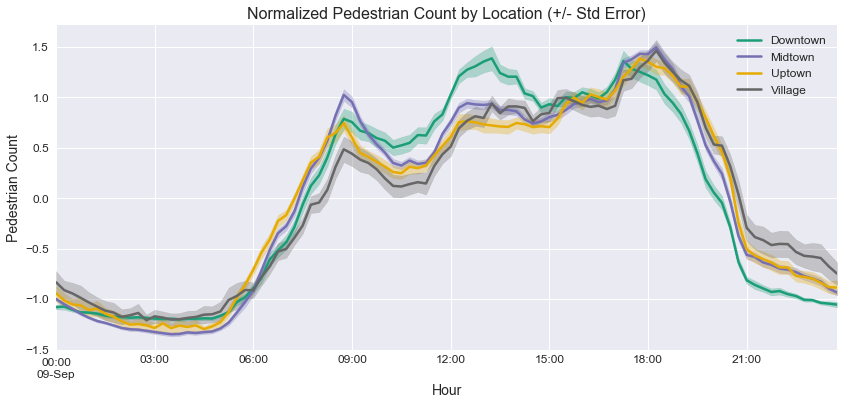

In [5]:
ts_std = cam_ts.groupby("location").std().T
ts_mean = cam_ts.groupby("location").mean().T
ts_count = cam_ts.groupby("location").size()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
color = iter(cm.Dark2(np.linspace(0, 1, len(ts_mean.columns))))

for col in ts_mean:
    c = next(color)
    ts_mean[col].plot(ax=ax, c=c, lw=2.5, label=col.title())
    ax.fill_between(ts_mean.index, 
                    ts_mean[col] + (ts_std[col] / np.sqrt(ts_count[col])), 
                    ts_mean[col] - (ts_std[col] / np.sqrt(ts_count[col])),
                    alpha=0.3, color=c)

ax.tick_params(axis="both", which="both", labelsize=12)
ax.set_xlabel("Hour", fontsize=14)
ax.set_ylabel("Pedestrian Count", fontsize=14)
ax.grid(True, which="both")
ax.legend(fontsize=12)
ax.set_title("Normalized Pedestrian Count by Location (+/- Std Error)", fontsize=16)